## Objective: 

Gain insights into the operational strengths and weaknesses of the supply chain, identify areas for improvement, and better understand the dynamics of supplying HIV-related products across different regions.

## Hypotheses

**Delivery Efficiency**: Countries managed by specific offices (managed_by) have more efficient delivery times due to better local infrastructure or more optimized supply chain operations.

**Cost Efficiency**: Shipments delivered via certain modes (shipment_mode) are more cost-effective when considering factors like freight cost, unit price, and insurance costs, even after accounting for delivery times.

**Product Demand and Supply**: Certain product_group or sub_classification items have higher demand variability, which significantly impacts procurement strategies and stock levels.

**Impact of Vendor Terms on Delivery**: The vendor_inco_term has a significant impact on delivery times and costs, affecting overall supply chain efficiency.

# Import packages

In [196]:

# data manipulation
import pandas as pd
import numpy as np

# data viz
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

#sql 
from pandasql import sqldf

# apply some cool styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

# Read data

In [200]:
#read in primary dataset and clean header names
data = pd.read_csv("../data/Supply_Chain_Shipment_Pricing_Dataset_20240302.csv",index_col="id")
data.columns = [i.strip().replace("/","").replace(" ","_").replace("#","num").replace("(","").replace(")","").replace("__","_").lower() for i in data.columns]

#reset index, old index was invalid
data = data.reset_index(drop=True)

# drop potentially duplicated rows
data = data.drop_duplicates()


#read in pqr dataset and clean header names
# pqr = pd.read_csv("../data/SearchTransactionData1.csv")
# pqr.columns = [i.strip().replace(" ","_").replace("#","num").replace("/","_").replace("(","").replace(")","").lower() for i in pqr.columns]

#join both datasets using country field as key
# joined = pd.merge(data,pqr,left_on="country",right_on="country_teritorry",how="inner").drop_duplicates()

In [228]:
data['scheduled_delivery_date'].min(),data['scheduled_delivery_date'].max()

(Timestamp('2006-05-02 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [229]:
data.columns

Index(['project_code', 'pq_num', 'po_so_num', 'asndn_num', 'country',
       'managed_by', 'fulfill_via', 'vendor_inco_term', 'shipment_mode',
       'pq_first_sent_to_client_date', 'po_sent_to_vendor_date',
       'scheduled_delivery_date', 'delivered_to_client_date',
       'delivery_recorded_date', 'product_group', 'sub_classification',
       'vendor', 'item_description', 'moleculetest_type', 'brand', 'dosage',
       'dosage_form', 'unit_of_measure_per_pack', 'line_item_quantity',
       'line_item_value', 'pack_price', 'unit_price', 'manufacturing_site',
       'first_line_designation', 'weight_kilograms', 'freight_cost_usd',
       'line_item_insurance_usd'],
      dtype='object')

In [225]:
pqr.columns

Index(['country_teritorry', 'grant_name',
       'supplier_agent_manufacturer_intermediatry', 'manufacturer',
       'product_category', 'product', 'description', 'product_pack',
       'pack_quantity', 'product_pack_usd', 'total_product_cost_usd',
       'purchase_order_date', 'scheduled_delivery_date',
       'actual_delivery_date', 'nb_of_suom_in_pack',
       'some_or_all_of_goods_prepaid', 'freight_cost',
       'supplier_invoice_number', 'purchase_order_number',
       'invoice_currency_name', 'primary_key', 'status'],
      dtype='object')

# Assess data quality, type conversions, cardinality & missing values proportions, and invalid fields

## Inspect data quality

In [201]:
display(data.head())
display(data.tail())

,project_code,pq_num,po_so_num,asndn_num,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,pq_first_sent_to_client_date,po_sent_to_vendor_date,scheduled_delivery_date,delivered_to_client_date,delivery_recorded_date,product_group,sub_classification,vendor,item_description,moleculetest_type,brand,dosage,dosage_form,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,line_item_insurance_usd
0,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,True,13,780.34,NaN
1,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",True,358,4521.5,NaN
2,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,True,171,1653.78,NaN
3,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",True,1855,16007.06,NaN
4,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",True,7590,45450.08,NaN


,project_code,pq_num,po_so_num,asndn_num,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,pq_first_sent_to_client_date,po_sent_to_vendor_date,scheduled_delivery_date,delivered_to_client_date,delivery_recorded_date,product_group,sub_classification,vendor,item_description,moleculetest_type,brand,dosage,dosage_form,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,line_item_insurance_usd
10319,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/2014,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",False,See DN-4307 (ID#:83920),See DN-4307 (ID#:83920),705.79
10320,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/2014,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,False,See DN-4313 (ID#:83921),See DN-4313 (ID#:83921),161.71
10321,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/2014,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,False,Weight Captured Separately,Freight Included in Commodity Cost,5284.04
10322,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/2015,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,True,1392,Freight Included in Commodity Cost,134.03
10323,103-ZW-T30,FPQ-15197,SO-50022,DN-4336,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/2014,N/A - From RDC,31-Aug-15,4-Aug-15,11-Aug-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Zidovudine 30/60mg, dispersible tab...",Lamivudine/Zidovudine,Generic,30/60mg,Chewable/dispersible tablet - FDC,60,36639,72911.61,1.99,0.03,"Cipla, Goa, India",False,Weight Captured Separately,Freight Included in Commodity Cost,85.82


Some initial observations when inspecting the header and footer of the dataset include:
* `pq_num`,`po_so_num`,`asndn_num`,`managed_by`,`dosage_form` are likely represented by primary-secondary label pairs, can potentially split on the attribute with a `-` delimeter in its value, as an extra grouping column
* `pq_first_sent_to_client_date`, `po_sent_to_vendor_date` has text fields instead of expected datetime values
* `dosage` has existing null values
* `vendor_inco_term`,`po_sent_to_vendor_date` has specific values alluding to null/unavailable dates
* `item_description`,`moleculetest_type`,`manufacturing_site`,`weight_kilograms`,`freight_cost_usd` may possess noisy string inconsistencies or duplicative values

## Convert to appropriate data types

In [202]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10320 entries, 0 to 10323
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   project_code                  10320 non-null  object 
 1   pq_num                        10320 non-null  object 
 2   po_so_num                     10320 non-null  object 
 3   asndn_num                     10320 non-null  object 
 4   country                       10320 non-null  object 
 5   managed_by                    10320 non-null  object 
 6   fulfill_via                   10320 non-null  object 
 7   vendor_inco_term              10320 non-null  object 
 8   shipment_mode                 9960 non-null   object 
 9   pq_first_sent_to_client_date  10320 non-null  object 
 10  po_sent_to_vendor_date        10320 non-null  object 
 11  scheduled_delivery_date       10320 non-null  object 
 12  delivered_to_client_date      10320 non-null  object 
 13  delive

Conversion steps, referencing data dictionary:
- Convert date fields to proper datetime Dtypes
- all other fields are correctly identified as object/int64/float64


Observations:
1. invalid text fiels for data columns: `po_sent_to_vendor_date`,`pq_first_sent_to_client_date` 
    < insert explanation here>


In [210]:
# replace invalid fields with nulls for date columns
data['po_sent_to_vendor_date'] = data['po_sent_to_vendor_date'].replace(['Date Not Captured', 'N/A - From RDC'],np.nan)
data['pq_first_sent_to_client_date'] = data['po_sent_to_vendor_date'].replace(['Date Not Captured', 'Pre-PQ Process'],np.nan)


date_cols = ['po_sent_to_vendor_date',
 'scheduled_delivery_date',
 'delivered_to_client_date',
 'delivery_recorded_date',
 'pq_first_sent_to_client_date'
 ]
display(data[date_cols])
for d in date_cols:
    data[d] = pd.to_datetime(data[d])

,po_sent_to_vendor_date,scheduled_delivery_date,delivered_to_client_date,delivery_recorded_date,pq_first_sent_to_client_date
0,NaT,2006-06-02,2006-06-02,2006-06-02,NaT
1,NaT,2006-11-14,2006-11-14,2006-11-14,NaT
2,NaT,2006-08-27,2006-08-27,2006-08-27,NaT
3,NaT,2006-09-01,2006-09-01,2006-09-01,NaT
4,NaT,2006-08-11,2006-08-11,2006-08-11,NaT
...,...,...,...,...,...
10319,NaT,2015-07-31,2015-07-15,2015-07-20,NaT
10320,NaT,2015-07-31,2015-08-06,2015-08-07,NaT
10321,NaT,2015-08-31,2015-08-25,2015-09-03,NaT
10322,NaT,2015-09-09,2015-08-04,2015-08-11,NaT


## Identify cardinality of each feature


In [222]:

#based on data dictionary and data types, we can expect low cardinality for binary (boolean) variables, and other variables of low factor level counts
# continuous attributes can take many possible values

data.nunique().to_frame('nunique').sort_values('nunique')


,nunique
first_line_designation,2
fulfill_via,2
managed_by,4
shipment_mode,4
product_group,5
sub_classification,6
vendor_inco_term,8
dosage_form,17
unit_of_measure_per_pack,31
country,43


In [223]:
data.describe(include=object).T

,count,unique,top,freq
project_code,10320,142,116-ZA-T30,768
pq_num,10320,1237,Pre-PQ Process,2678
po_so_num,10320,6233,SCMS-199289,67
asndn_num,10320,7030,ASN-19166,54
country,10320,43,South Africa,1406
managed_by,10320,4,PMO - US,10261
fulfill_via,10320,2,From RDC,5401
vendor_inco_term,10320,8,N/A - From RDC,5401
shipment_mode,9960,4,Air,6109
product_group,10320,5,ARV,8548


The only boolean field is `first_line_designation` and should be a binary attribute with 2 possible values (T/F). `fulfill_via` is another binary column.

## Clean categorical features with noisy text fields

`item_description`,`moleculetest_type`,`manufacturing_site`,`weight_kilograms`,`freight_cost_usd` 

In [218]:
text_fields = ['item_description','moleculetest_type','manufacturing_site','weight_kilograms','freight_cost_usd']
for t in text_fields:
    display(data[[t]].drop_duplicates().sort_values(t))

,item_description
15,"#102198**Didanosine 200mg [Videx], tablets, 60..."
39,"#108853** HIV, Genie II HIV-1/HIV-2 Kit, 40 Tests"
843,"#109435**HIV, OraQuick Controls Kit, 3 Vials"
75,"#109436**HIV 1, Uni-Gold Recombigen HIV Contro..."
224,"#109440**HIV 1/2, INSTI HIV Antibody Individua..."
...,...
251,"Zidovudine 10mg/ml [Retrovir], solution for IV..."
2725,"Zidovudine 10mg/ml, oral solution w/syringe, B..."
5,"Zidovudine 10mg/ml, oral solution, Bottle, 240 ml"
109,"Zidovudine 300mg [Retrovir], tablets, 60 Tabs"


,moleculetest_type
62,Abacavir
2870,Abacavir/Lamivudine
401,Abacavir/Lamivudine/Zidovudine
64,Artemether/Lumefantrine
72,Artesunate+Amodiaquine
...,...
48,Saquinavir
4,Stavudine
597,Sulfadoxine/Pyrimethamine
33,Tenofovir Disoproxil Fumarate


,manufacturing_site
140,ABBSP
122,ABBVIE (Abbott) France
779,ABBVIE (Abbott) Japan Co. Ltd.
82,ABBVIE (Abbott) Logis. UK
9,ABBVIE (Abbott) St. P'burg USA
...,...
27,"Standard Diagnostics, Korea"
138,"Strides, Bangalore, India."
11,"Trinity Biotech, Plc"
953,"Weifa A.S., Hausmanngt. 6, P.O. Box 9113 GrÃ¸n..."


,weight_kilograms
3286,0
75,1
97,10
76,100
451,1000
...,...
1556,See DN-990 (ID#:11001)
2418,See DN-992 (ID#:11602)
2408,See DN-993 (ID#:11919)
1978,See DN-998 (ID#:11568)


,freight_cost_usd
35,0.75
8460,1000.05
1408,1000.51
5826,1000.94
4576,1001.02
...,...
2017,See DN-988 (ID#:11022)
1556,See DN-990 (ID#:11001)
2418,See DN-992 (ID#:11602)
2408,See DN-993 (ID#:11919)


In [224]:
data.dtypes

project_code                            object
pq_num                                  object
po_so_num                               object
asndn_num                               object
country                                 object
managed_by                              object
fulfill_via                             object
vendor_inco_term                        object
shipment_mode                           object
pq_first_sent_to_client_date    datetime64[ns]
po_sent_to_vendor_date          datetime64[ns]
scheduled_delivery_date         datetime64[ns]
delivered_to_client_date        datetime64[ns]
delivery_recorded_date          datetime64[ns]
product_group                           object
sub_classification                      object
vendor                                  object
item_description                        object
moleculetest_type                       object
brand                                   object
dosage                                  object
dosage_form  

## Calculate proportion of missing values

In [204]:
data.isnull().sum()/data.shape[0]*100

project_code                     0.000000
pq_num                           0.000000
po_so_num                        0.000000
asndn_num                        0.000000
country                          0.000000
managed_by                       0.000000
fulfill_via                      0.000000
vendor_inco_term                 0.000000
shipment_mode                    3.488372
pq_first_sent_to_client_date     0.000000
po_sent_to_vendor_date           0.000000
scheduled_delivery_date          0.000000
delivered_to_client_date         0.000000
delivery_recorded_date           0.000000
product_group                    0.000000
sub_classification               0.000000
vendor                           0.000000
item_description                 0.000000
moleculetest_type                0.000000
brand                            0.000000
dosage                          16.802326
dosage_form                      0.000000
unit_of_measure_per_pack         0.000000
line_item_quantity               0

* `dosage` has about 16.8% missing values, may perform imputation
* `shipment_mode` and `line_item_insurance_usd` has 3.4% and 2.8% missing values, respectively

# Imputation of missing values

In [165]:
data[date_cols].isnull().sum()/data.shape[0]

po_sent_to_vendor_date          0.555136
scheduled_delivery_date         0.000000
delivered_to_client_date        0.000000
delivery_recorded_date          0.000000
pq_first_sent_to_client_date    0.555136
dtype: float64

date columns are now cleaned by replacing strings indicating dates are missing with null

To analyze for operational efficiency, we will not drop this column from the analysis, but will drop rows with missing dates

In [207]:
data.loc[data['po_sent_to_vendor_date'].isna()]['pq_first_sent_to_client_date'].dropna()

Series([], Name: pq_first_sent_to_client_date, dtype: datetime64[ns])

It's worth noting that when `po_sent_to_vendor_date` is missing, the corresponding `pq_first_sent_to_client_date` is also missing

In [208]:
display(data.filter(like="po")\
        .query('po_sent_to_vendor_date != "NaT"')\
        .drop_duplicates())

sqldf("""
      select 
            po_so_num,
            count(po_sent_to_vendor_date) as count_po_date
      from data 
      where po_sent_to_vendor_date != 'NaT'
      group by po_so_num
      order by count(po_sent_to_vendor_date) desc
      
      """)


,po_so_num,po_sent_to_vendor_date
9,SCMS-165,2006-11-13
10,SCMS-221,2006-12-01
13,SCMS-268,2006-12-22
15,SCMS-308,2007-01-10
18,SCMS-156150,2012-08-15
...,...,...
6560,SCMS-70130,2010-04-23
6562,SCMS-139640,2012-04-09
6571,SCMS-153080,2012-07-12
6576,SCMS-296460,2015-08-04


,po_so_num,count_po_date
0,SCMS-199289,67
1,SCMS-199283,63
2,SCMS-259075,38
3,SCMS-215370,38
4,SCMS-259079,33
...,...,...
2689,SCMS-100470,1
2690,SCMS-100301,1
2691,SCMS-100300,1
2692,SCMS-100090,1


Since a PO # can have many possible associated dates, missing dates cannot be imputed considering the high % of nulls

In [168]:
display(data.filter(like="pq")\
        .query('pq_first_sent_to_client_date != "NaT"')\
        .drop_duplicates())

sqldf("""
      select 
            pq_num,
            count(pq_first_sent_to_client_date) as count_pq_date
      from data 
      where pq_first_sent_to_client_date != 'NaT'
      group by pq_num
      order by count(pq_first_sent_to_client_date) desc
      
      """)

,pq_num,pq_first_sent_to_client_date
9,Pre-PQ Process,2006-11-13
10,Pre-PQ Process,2006-12-01
13,Pre-PQ Process,2006-12-22
15,Pre-PQ Process,2007-01-10
18,FPQ-10286,2012-08-15
...,...,...
6547,FPQ-8116,2012-04-05
6551,FPQ-15346,2014-12-08
6556,FPQ-10555,2012-08-29
6559,FPQ-6966,2011-02-02


,pq_num,count_pq_date
0,Pre-PQ Process,750
1,FPQ-14942,205
2,FPQ-12522,154
3,FPQ-13973,110
4,FPQ-7175,78
...,...,...
773,FPQ-10558,1
774,FPQ-10555,1
775,FPQ-10289,1
776,FPQ-10107,1


Likewise, since a PQ # can have many possible associated dates, missing dates cannot be imputed considering the high % of nulls

# Curse of Dimensionality
Discussion here...

# Correlation Analysis

1. Extract numerical columns
2. Find correlation matrix and plot

In [176]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

data.select_dtypes(include=numerics).corr()

,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,line_item_insurance_usd
unit_of_measure_per_pack,1.000000,-0.151107,-0.128748,0.097156,-0.102800,-0.131912
line_item_quantity,-0.151107,1.000000,0.839070,-0.133622,-0.052219,0.798646
line_item_value,-0.128748,0.839070,1.000000,-0.018768,-0.019574,0.961350
pack_price,0.097156,-0.133622,-0.018768,1.000000,0.250048,-0.015350
unit_price,-0.102800,-0.052219,-0.019574,0.250048,1.000000,-0.021423
line_item_insurance_usd,-0.131912,0.798646,0.961350,-0.015350,-0.021423,1.000000


<Axes: >

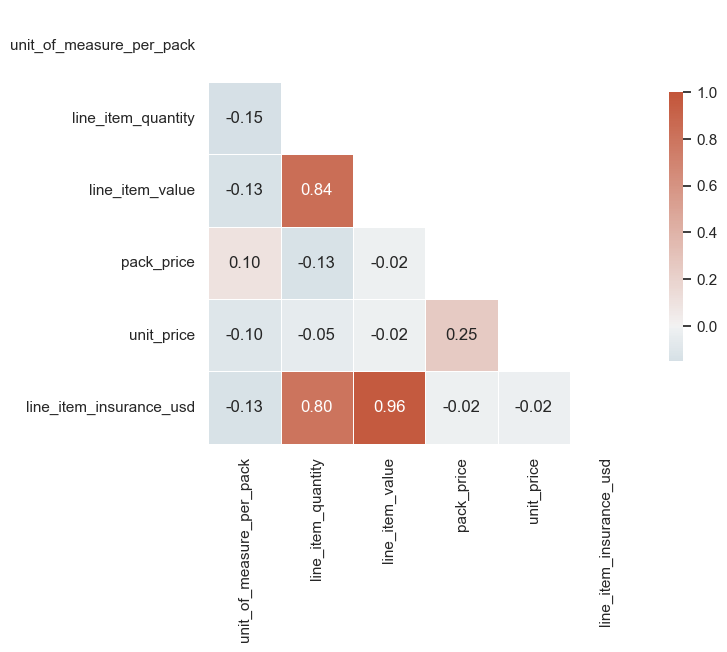

In [178]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = data.select_dtypes(include=numerics).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,annot=True,fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

`line_item_insurance_usd` seems to be highly associated with `line_item_quantity` and `line_item_value`

# Feature Engineering

Generate additional features based on date attributes

In [66]:
data['delivery_diff'] = data['delivered_to_client_date'] - data['scheduled_delivery_date']
data['delivery_diff_days'] = data['delivery_diff']/np.timedelta64(1,'D')
data['delivery_diff_days'].value_counts()

delivery_diff_days
 0.0      6324
-17.0      127
-6.0       119
-8.0       112
-13.0      107
          ... 
-152.0       1
-144.0       1
-368.0       1
 77.0        1
-99.0        1
Name: count, Length: 235, dtype: int64

# Generating insights with SQL

In [109]:
# average prices statified by delivery status, vendor, frequency
sqldf('''with status as (
          select *,
          case 
            when delivery_diff_days = 0 then 'on time'
            when delivery_diff_days < 0 then 'early'
          else 'late'
          end as 'delivery_status'
          from data)
          select 
            delivery_status,product_group,sub_classification,shipment_mode,
            count(delivery_status) as status_freq,
            avg(freight_cost_usd) as avg_freight_cost_usd,
            avg(pack_price) as avg_pack_price,
            avg(unit_price) as avg_unit_price,
            avg(line_item_value) as avg_line_item_value,
            avg(line_item_insurance_usd) as avg_line_item_insurance_usd
          from status
          group by delivery_status,product_group,sub_classification,shipment_mode
          order by delivery_status desc, product_group desc, sub_classification, status_freq desc''')
          

,delivery_status,product_group,sub_classification,shipment_mode,status_freq,avg_freight_cost_usd,avg_pack_price,avg_unit_price,avg_line_item_value,avg_line_item_insurance_usd
0,on time,MRDT,Malaria,Air,7,1163.228571,28.735714,1.055714,9491.442857,14.380000
1,on time,MRDT,Malaria,None,1,186.250000,37.500000,1.500000,14625.000000,23.400000
2,on time,HRDT,HIV test,Air,1283,10333.893936,73.027163,2.519906,121238.585861,187.454201
3,on time,HRDT,HIV test,None,43,2901.037674,86.146977,2.572093,49434.511628,78.619231
4,on time,HRDT,HIV test,Truck,38,795.641579,74.885526,1.217105,126865.458947,223.329737
5,on time,HRDT,HIV test,Ocean,4,18096.790000,44.000000,1.400000,331760.000000,547.402500
6,on time,HRDT,HIV test - Ancillary,Air,128,1835.085625,6.646094,2.990703,2819.202031,4.115781
7,on time,HRDT,HIV test - Ancillary,Truck,9,263.986667,1.397778,0.840000,2237.833333,2.391111
8,on time,HRDT,HIV test - Ancillary,None,5,782.798000,47.738000,47.730000,104.718000,0.164000
9,on time,ARV,Adult,Air,2197,6635.565676,17.967101,0.281097,128435.243787,203.436535


In [121]:
# average prices statified by delivery status, vendor, frequency for on time deliveries
sqldf("""with status as (
          select *,
          case 
            when delivery_diff_days = 0 then 'on time'
            when delivery_diff_days < 0 then 'early'
          else 'late'
          end as 'delivery_status'
          from data)
          select 
            delivery_status,vendor,
            count(delivery_status) as status_freq,
            avg(freight_cost_usd) as avg_freight_cost_usd,
            avg(pack_price) as avg_pack_price,
            avg(unit_price) as avg_unit_price,
            avg(line_item_value) as avg_line_item_value,
            avg(line_item_insurance_usd) as avg_line_item_insurance_usd
          from status
          where delivery_status = 'on time'
          group by delivery_status,vendor
          order by status_freq desc
          limit 10
          """)
          

,delivery_status,vendor,status_freq,avg_freight_cost_usd,avg_pack_price,avg_unit_price,avg_line_item_value,avg_line_item_insurance_usd
0,on time,SCMS from RDC,2068,5136.092021,16.084483,0.413617,155912.813153,264.791573
1,on time,"Orgenics, Ltd",592,11540.338429,68.791588,1.052399,177320.315456,265.053395
2,on time,Aurobindo Pharma Limited,552,7057.416576,7.210797,0.148207,120203.041250,202.635824
3,on time,S. BUYS WHOLESALER,464,0.000000,21.179806,0.382845,12942.126379,21.941595
4,on time,"Trinity Biotech, Plc",353,6512.133229,39.543938,1.743739,58682.156516,90.077442
5,on time,ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV),341,5618.974868,39.353548,0.294457,85355.307214,135.537589
6,on time,PHARMACY DIRECT,326,0.000000,25.098896,0.439632,2678.943742,3.121196
7,on time,MYLAN LABORATORIES LTD (FORMERLY MATRIX LABORA...,310,9954.141484,10.609355,0.284710,230027.868355,329.367323
8,on time,HETERO LABS LIMITED,266,9693.650113,5.729211,0.146353,153332.114850,206.352970
9,on time,CIPLA LIMITED,146,11727.000959,7.779658,0.137123,218336.096781,346.024676


In [152]:
# top 10 countries with most deliveries
sqldf('''
      select 
        vendor,country,
        count(delivered_to_client_date) as count_deliveries
      from data
      group by vendor,country
      order by count_deliveries desc
      limit 10
      ''')

,vendor,country,count_deliveries
0,SCMS from RDC,Nigeria,927
1,SCMS from RDC,Côte d'Ivoire,825
2,S. BUYS WHOLESALER,South Africa,715
3,SCMS from RDC,Uganda,573
4,SCMS from RDC,Zambia,541
5,SCMS from RDC,Mozambique,507
6,SCMS from RDC,Zimbabwe,428
7,PHARMACY DIRECT,South Africa,326
8,SCMS from RDC,Haiti,312
9,SCMS from RDC,Tanzania,301


In [170]:
# finding hotspots, the top 3 locations per vendor
sqldf('''
      select vendor, country,count_deliveries,rn
      from (
      select vendor, country,count_deliveries,
        ROW_NUMBER() OVER (PARTITION BY vendor ORDER BY count_deliveries DESC) as rn
      from (
      select 
        vendor,country,
        count(delivered_to_client_date) as count_deliveries
      from data
      group by vendor,country))
      where rn <= 3 and count_deliveries > 10
      order by count_deliveries desc
      ''')

,vendor,country,count_deliveries,rn
0,SCMS from RDC,Nigeria,927,1
1,SCMS from RDC,Côte d'Ivoire,825,2
2,S. BUYS WHOLESALER,South Africa,715,1
3,SCMS from RDC,Uganda,573,3
4,PHARMACY DIRECT,South Africa,326,1
5,Aurobindo Pharma Limited,South Africa,212,1
6,MYLAN LABORATORIES LTD (FORMERLY MATRIX LABORA...,Vietnam,161,1
7,Aurobindo Pharma Limited,Vietnam,160,2
8,HETERO LABS LIMITED,Vietnam,150,1
9,"Orgenics, Ltd",Nigeria,136,1


In [174]:
# where most products are being produced (mfg sites)
sqldf('''
      select manufacturing_site,count(*) as count_mfg from data
      group by manufacturing_site
      order by count_mfg desc
      limit 10
      ''')

,manufacturing_site,count_mfg
0,"Aurobindo Unit III, India",3172
1,Mylan (formerly Matrix) Nashik,1415
2,Hetero Unit III Hyderabad IN,869
3,"Cipla, Goa, India",665
4,"Strides, Bangalore, India.",540
5,"Alere Medical Co., Ltd.",481
6,"Trinity Biotech, Plc",405
7,ABBVIE Ludwigshafen Germany,366
8,Inverness Japan,345
9,ABBVIE (Abbott) Logis. UK,219


In [183]:
# most popular products per mfg site
sqldf('''
      select manufacturing_site,product_group,count_product_group,rn
      from (
      select manufacturing_site,product_group,count_product_group,
        ROW_NUMBER() OVER (PARTITION BY manufacturing_site ORDER BY count_product_group DESC) as rn
      from (
      select 
        manufacturing_site,product_group,
        count(product_group) as count_product_group
      from data
      group by manufacturing_site))
      where rn <= 3
      order by count_product_group desc
      ''')

,manufacturing_site,product_group,count_product_group,rn
0,"Aurobindo Unit III, India",ARV,3172,1
1,Mylan (formerly Matrix) Nashik,ARV,1415,1
2,Hetero Unit III Hyderabad IN,ARV,869,1
3,"Cipla, Goa, India",ARV,665,1
4,"Strides, Bangalore, India.",ARV,540,1
...,...,...,...,...
83,Mepro Pharm Wadhwan Unit II,ANTM,1,1
84,"OMEGA Diagnostics, UK",HRDT,1,1
85,Premier Medical Corporation,MRDT,1,1
86,"Remedica, Limassol, Cyprus",ANTM,1,1


In [191]:
# most popular products per mfg site
sqldf('''
      select 
        manufacturing_site,
        count(distinct vendor) as count_vendor
      from data
      group by manufacturing_site
      order by count_vendor desc
      ''')

,manufacturing_site,count_vendor
0,"Alere Medical Co., Ltd.",7
1,ABBVIE Ludwigshafen Germany,7
2,ABBVIE (Abbott) Logis. UK,7
3,Inverness Japan,6
4,"Aurobindo Unit III, India",6
...,...,...
83,"Boehringer Ing., Koropi, GR",1
84,BUNDI INTERNATIONAL DIAGNOSTICS LTD,1
85,"Access BIO, L.C.",1
86,ABBVIE Labs North Chicago US,1


In [195]:
# most popular products per mfg site
sqldf('''
      select 
        manufacturing_site,brand,count(*) as count_brands
      from data
      group by manufacturing_site,brand
      order by count_brands desc
      ''')

,manufacturing_site,brand,count_brands
0,"Aurobindo Unit III, India",Generic,3172
1,Mylan (formerly Matrix) Nashik,Generic,1415
2,Hetero Unit III Hyderabad IN,Generic,869
3,"Cipla, Goa, India",Generic,665
4,"Strides, Bangalore, India.",Generic,540
...,...,...,...
125,Premier Medical Corporation,Generic,1
126,"Remedica, Limassol, Cyprus",Generic,1
127,Roche Basel,Viracept,1
128,"Standard Diagnostics, Korea",Generic,1


In [199]:
# most popular products per mfg site
sqldf('''
      select 
        brand,
        dosage_form,
        count(*) as count_brands,
        avg(unit_price) as avg_unit_price
      from data
      group by brand,dosage_form
      order by count_brands desc
      limit 10
      ''')

,brand,dosage_form,count_brands,avg_unit_price
0,Generic,Tablet,2964,0.188988
1,Generic,Tablet - FDC,2618,0.218293
2,Determine,Test kit,725,0.813655
3,Generic,Capsule,489,0.093517
4,Generic,Oral solution,468,0.026239
5,Uni-Gold,Test kit,369,1.605556
6,Aluvia,Tablet,250,0.361000
7,Generic,Chewable/dispersible tablet - FDC,239,0.055105
8,Generic,Oral suspension,202,0.011733
9,Kaletra,Oral solution,158,0.112152
